In [1]:
import torch
import create_cfg_model as cm
import coco_data #사전에 로드해야할 변수 데이터 

In [2]:
# 새로이 추가한 기능 - yolo v3 모델 인스턴스화
cfg_file = "yolov3.cfg"
weight_file = "YOLOv3-416.weights"

# CFG 정보 파싱
blocks = cm.parse_cfg(cfg_file)

# CFG 모델 인스턴스화
cfg_model = cm.Yolo_v3_cfg(blocks)
#  pre-trained weights로 CFG 모델 초기화
cm.load_weights(cfg_model, weight_file)

In [3]:
# create_cfg_model.py에 구현한
# anchorbox의 좌표를 정규좌표평면에 위치하도록
# 좌표 변환을 해주는 함수

# yolov3.cfg 파일의 width, height는 꼭 416으로 수정!!
# yolov3.cfg 파일의 width, height는 꼭 416으로 수정!!
# yolov3.cfg 파일의 width, height는 꼭 416으로 수정!!
# yolov3.cfg 파일의 width, height는 꼭 416으로 수정!!
cfg_anchor_box_list = cm.convert_anchor(cfg_file)
print(cfg_anchor_box_list)

tensor([[[0.0240, 0.0312],
         [0.0385, 0.0721],
         [0.0793, 0.0553]],

        [[0.0721, 0.1466],
         [0.1490, 0.1082],
         [0.1418, 0.2861]],

        [[0.2788, 0.2163],
         [0.3750, 0.4760],
         [0.8966, 0.7837]]])


In [4]:
import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# 모델의 출력 outputs의 bbox를 필터링하는 nms 클래스
from yolo_v3_nms import Yolov3NMS

from pycocotools.coco import COCO

In [5]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'
anno_path = os.path.join(root_dir, 'annotations')
load_anno = 'val2014'
json_file = 'instances_' + load_anno + '.json'
coco = COCO(os.path.join(anno_path, json_file))

loading annotations into memory...
Done (t=4.03s)
creating index...
index created!


In [46]:
# 임의의 이미지 하나 선택하기
img_ids = coco.getImgIds()
chosen_img = random.choice(img_ids)

img_info = coco.loadImgs(chosen_img)[0]
img_file_name = img_info['file_name']
print(img_file_name)

COCO_val2014_000000420704.jpg


In [47]:
# 이미지 불러오기 및 전처리
image_path =  os.path.join(root_dir, load_anno, img_file_name)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (416, 416))
image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

In [48]:
# gt_box 정보 추출하기
ann_ids = coco.getAnnIds(imgIds=chosen_img)
anns = coco.loadAnns(ann_ids)

gt_boxes = []

for ann in anns:
    bbox = ann['bbox']
    # CP는 Class Probability이니 = Class ID
    CP_idx = coco_data.real_class_idx[ann['category_id']]

    x, y, w, h = bbox
    # bbox 좌표 정규화
    bx = (x + w / 2) / img_info['width']
    by = (y + h / 2) / img_info['height']
    bw = w / img_info['width']
    bh = h / img_info['height']

    gt_box = torch.tensor([bx, by, bw, bh, 1, CP_idx])
    gt_boxes.append(gt_box)

gt_boxes = sorted(gt_boxes, key=lambda box: (box[5], box[2] * box[3]))

# 정규 좌표평면상으로 변환한 GT_b_series_bbox 좌표 리스트 출력
for gt_box in gt_boxes:
    print(gt_box)

tensor([ 0.5330,  0.4651,  0.9339,  0.6577,  1.0000, 55.0000])


In [49]:
# 모델 추론
with torch.no_grad():
    outputs = cfg_model(image_tensor)

# NMS 적용을 위한 nms 클래스 인스턴스화
# 이때 `anchor` 변수는 앞서 정규 좌표평면의 anthor_box_list를 인자로
nms = Yolov3NMS(conf_th=0.4, anchor=cfg_anchor_box_list)
# 아래의 메서드가 수행되면 [tx, ty, tw, th] -> [bx, by, bw, bh] 좌표변환
# 그 이후 NMS 필터가 한번에 다 돌아감
boxes = nms.non_max_suppression(outputs)

boxes = sorted(boxes, key=lambda box: (box[5], box[2] * box[3]))

# 최종 모델이 추론한 정보인 B_series_bbox 좌표 리스트 출력
for box in boxes:
    print(box)


tensor([ 0.9457,  0.7099,  0.1099,  0.1773,  0.6332, 51.0000])
tensor([ 0.5492,  0.5067,  0.9765,  0.9060,  0.8687, 55.0000])


In [25]:
# 결과 시각화 함수
def plot_boxes(image, boxes, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # 정규 좌표값 boxes를 원래 값으로 복원
    scale_y = image.shape[0] # height
    scale_x = image.shape[1] # width
    boxes = [[box[0] * scale_x, # x_center * width
              box[1] * scale_y, # y_center * height
              box[2] * scale_x, # w * width
              box[3] * scale_y, # h * height
              box[4], box[5]] for box in boxes]

    for box in boxes:
        x_center, y_center, w, h, conf, label = box
        # bbox를 그리는데 좌 상단 좌표, width, hight 필요
        x1 = x_center - w / 2
        y1 = y_center - h / 2

        # 라벨의 텍스트 좌표 및 bbox의 색깔 정하기
        label = int(label)
        superclass = coco_data.cls_map[label]
        color = coco_data.cls_color[superclass]

        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, s=labels[label], color='black', verticalalignment='top',
                 bbox={'color': color, 'pad': 0})

    plt.axis('off')
    plt.show()

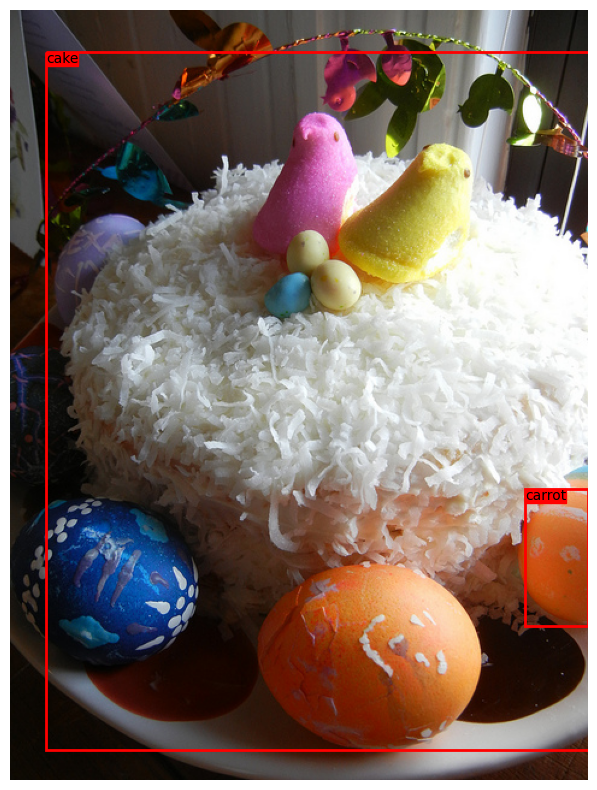

In [50]:
# 모델 추론 결과 -> B_series좌표변환 -> NMS 필터 후 결과 시각화
plot_boxes(image_rgb, boxes, coco_data.coco_label)

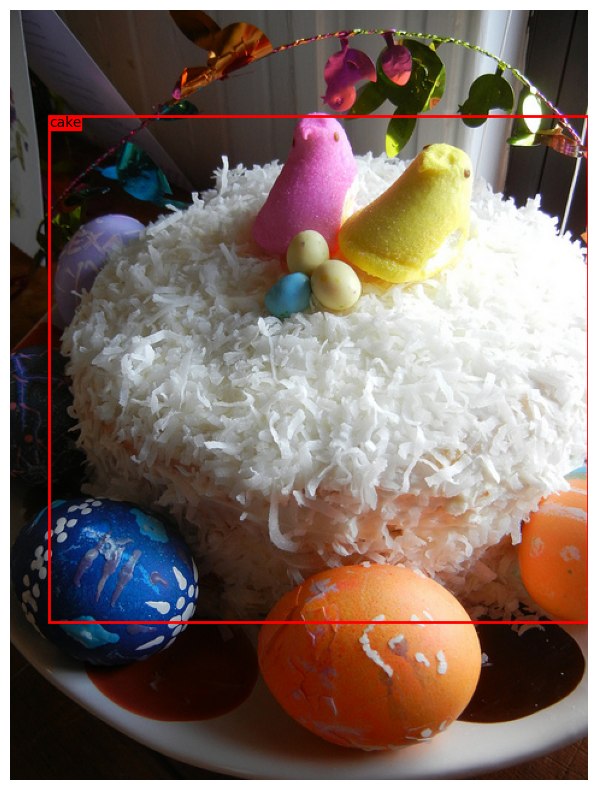

In [51]:
# Ground_Truth 좌표에 대한 결과 시각화
plot_boxes(image_rgb, gt_boxes, coco_data.coco_label)